# Getting Started

Natural Language Processing with Disaster Tweets is a Kaggle Challenge where tweets are collected with labels indicating whether the tweets are about a disaster that occurred or not. Since tweets are social media language, therefore, it is a challenge to automatically identify them. Besides, ambiguity in texts makes it more difficult to achieve automatic identification of tweets containing information on real disaster. The objective of this project is to predict using machine learning if a tweet contains information on occurrence of a real disaster or not.

Data Source - https://www.kaggle.com/c/nlp-getting-started

## Imports

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['font.size'] = 15

from collections import Counter
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import contractions
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, QuantileTransformer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

## Data Load

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

# Exploratory Data Analysis

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.shape

(7613, 5)

In [5]:
for col in df_train.columns:
    print("{} has {} unique instances".format(col, len(df_train[col].unique())))

id has 7613 unique instances
keyword has 222 unique instances
location has 3342 unique instances
text has 7503 unique instances
target has 2 unique instances


There are 7613 unique ids which is in accordance with the dataframe shape.

Target has two classes. This is expected since this is a binary classification task

In [6]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train.isnull().sum() * 100  / len(df_train)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Keyword and location has missing values. Location has 33% data missing. This missing data could be atckled by detecting location in tweets and filling them up. I will not be doing this since I will be using tf-idf on the tweet text joined with location. Therefore, this step is not required for modelling though could be useful for EDA.  

In [8]:
df_train[~df_train['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


Evident that the location information is not consistant. It is also possible to extract location information from text as in id 50.

In [9]:
df_train[df_train['id'] == 48]['text']

31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
Name: text, dtype: object

## Column Names - STATIC

I prefer standardizing column names:

In [10]:
KEYWORD = 'keyword'
ID = 'id'
LOCATION = 'location'
TEXT = 'text'
TARGET = 'target'
TEXT_TOKENIZED = 'Text Tokenized'
SENTIMENT = 'Sentiment Score'
SENTIMENT_ROUND = 'Sentiment Score (rounded off)'
_LOC_POINT = '_loc_point'
WORDS_PER_TWEET = 'Words Per Tweet'
CHAR_PER_TWEET = 'Characters Per Tweet'
LOCATIONS = 'Locations'
_LOC_SPACY_OBJ_ = 'Location Spacy Object'
ALL_TEXT = 'all_text'
ALL_TEXT_JOINED = 'all_text_joined'
NUM_IN_TWEETS = 'Number in Tweet'
PUNCTUATION_COUNT = 'Punctuation Count Per Tweet'
IDENTIFIABLE_LOCATION = 'Identifiable Location'
IN_BOW = 'Present In BOW'

## Keyword Analysis

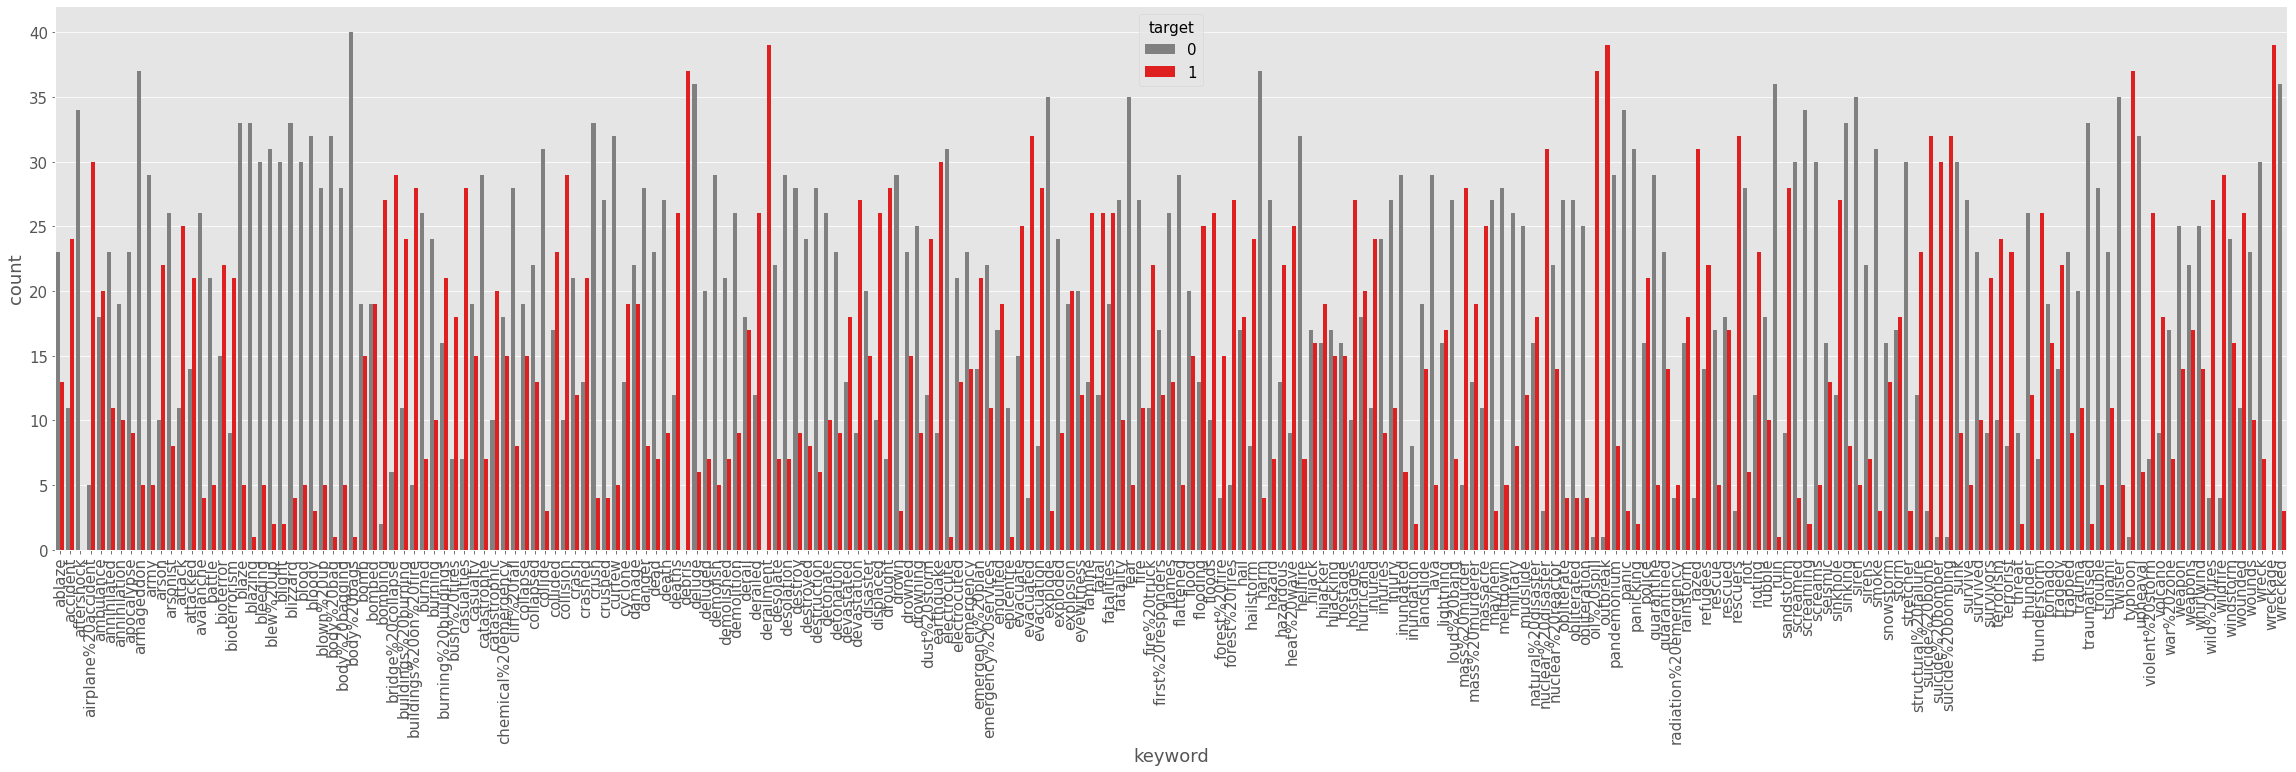

In [11]:
plt.figure(figsize=[40, 10])
sns.countplot(x=KEYWORD, hue=TARGET, data=df_train, palette=['grey', 'red'])
plt.xticks(rotation=90)
plt.show()

Blank spaces indicated by %20. Will require to clean this.

From this chart, it is seen that 'derailment', 'debris' and 'wreckage' are all about real disaster tweets. Body20%bags contains the higest difference between real and non-real disaster tweets where the number of non-real disaster tweets is high. It is actually the highest.

In [12]:
df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['@FoxNews @JenGriffinFNC When you call to report dangerous activity tell em to have body bags on arrival.'],
      dtype=object)

In [13]:
real_disaster_keywords = df_train[df_train['target'] == 1].groupby(['keyword', 'target']).count()['id'].reset_index()
real_disaster_keywords.head()

,keyword,target,id
0,ablaze,1,13
1,accident,1,24
2,airplane%20accident,1,30
3,ambulance,1,20
4,annihilated,1,11


In [14]:
unreal_disaster_keywords = df_train[df_train['target'] == 0].groupby(['keyword', 'target']).count()['id'].reset_index()
unreal_disaster_keywords.head()

,keyword,target,id
0,ablaze,0,23
1,accident,0,11
2,aftershock,0,34
3,airplane%20accident,0,5
4,ambulance,0,18


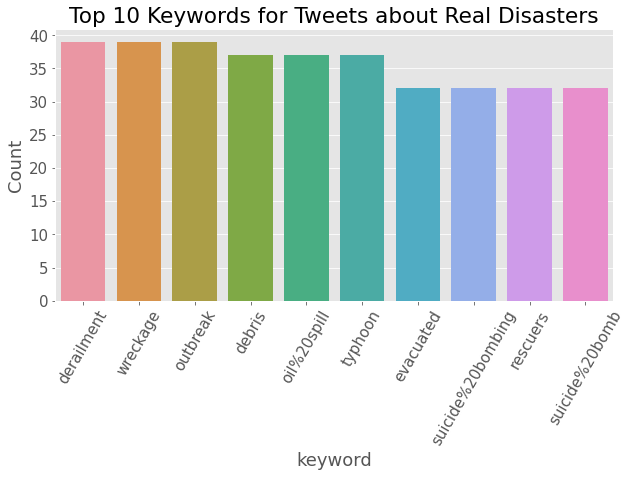

In [15]:
plt.figure(figsize=[10, 5])
sns.barplot(x=KEYWORD, y=ID, data=real_disaster_keywords.sort_values('id', ascending=False)[:10])
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Top 10 Keywords for Tweets about Real Disasters')
plt.show()

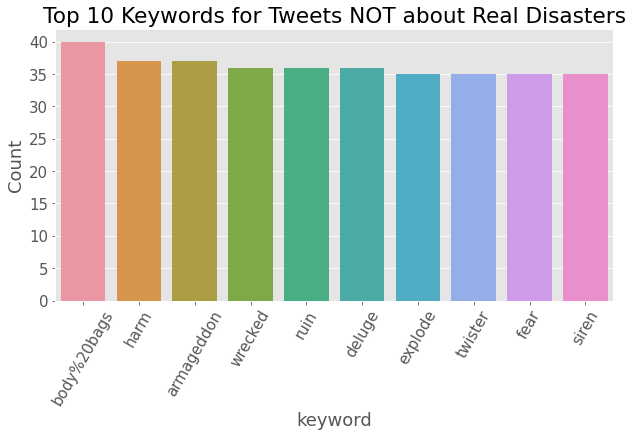

In [16]:
plt.figure(figsize=[10, 5])
sns.barplot(x=KEYWORD, y=ID, data=unreal_disaster_keywords.sort_values('id', ascending=False)[:10])
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Top 10 Keywords for Tweets NOT about Real Disasters')
plt.show()

In [17]:
merged_counts_keywords = pd.merge(
    left=real_disaster_keywords,
    right=unreal_disaster_keywords,
    left_on=KEYWORD,
    right_on=KEYWORD,
    how='outer').drop(columns=['target_x', 'target_y']).fillna(0)

merged_counts_keywords['prob_real_disasters'] = (
    merged_counts_keywords['id_x'] -
    merged_counts_keywords['id_y']) / merged_counts_keywords['id_x']
merged_counts_keywords

,keyword,id_x,id_y,prob_real_disasters
0,ablaze,13.0,23.0,-0.769231
1,accident,24.0,11.0,0.541667
2,airplane%20accident,30.0,5.0,0.833333
3,ambulance,20.0,18.0,0.100000
4,annihilated,11.0,23.0,-1.090909
...,...,...,...,...
216,wounds,10.0,23.0,-1.300000
217,wreck,7.0,30.0,-3.285714
218,wreckage,39.0,0.0,1.000000
219,wrecked,3.0,36.0,-11.000000


In [18]:
top_prob_real_disaster_keywords = merged_counts_keywords.sort_values('prob_real_disasters', ascending=False)[:10]
top_prob_real_disaster_keywords

,keyword,id_x,id_y,prob_real_disasters
69,derailment,39.0,0.0,1.000000
61,debris,37.0,0.0,1.000000
218,wreckage,39.0,0.0,1.000000
152,outbreak,39.0,1.0,0.974359
204,typhoon,37.0,1.0,0.972973
151,oil%20spill,37.0,1.0,0.972973
186,suicide%20bombing,32.0,1.0,0.968750
185,suicide%20bomber,30.0,1.0,0.966667
31,bombing,27.0,2.0,0.925926
165,rescuers,32.0,3.0,0.906250


## Target Imabalance

In [19]:
df_train.target.value_counts() / len(df_train)

0    0.57034
1    0.42966
Name: target, dtype: float64

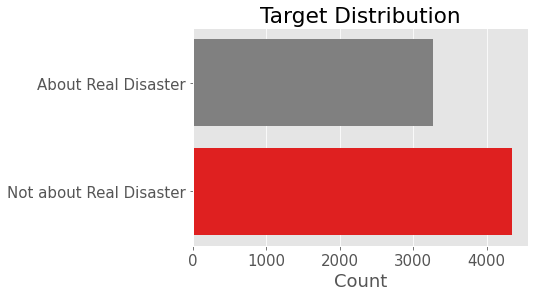

In [20]:
sns.countplot(y=TARGET,
              data=df_train[TARGET].replace({
                  0: 'Not about Real Disaster',
                  1: 'About Real Disaster'
              }).reset_index(),
              palette=['grey', 'red'])
plt.title('Target Distribution')
plt.ylabel(None)
plt.xlabel('Count')
plt.show()

This dataset is imbalanced. The disprity is of ~1000 datapoints where the number of non-disastrous tweets are higher.

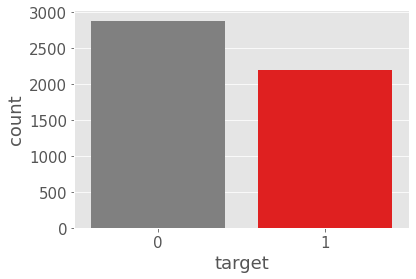

In [21]:
sns.countplot(x=TARGET, data=df_train[~df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

For the tweets whose location is NOT missing, the data imabalance is true in this case as well. Therefore, dropping the location null data will not help balancing the data.

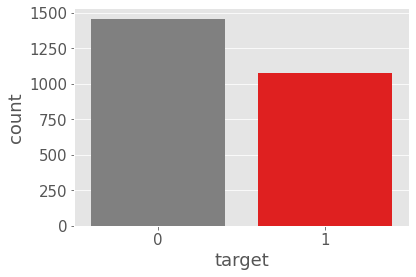

In [22]:
sns.countplot(x=TARGET, data=df_train[df_train[LOCATION].isna()], palette=['grey', 'red'])
plt.show()

For the tweets whose location is missing, the data imabalance is true in this case as well.

## Top 20 locations

In [23]:
df_train[df_train[TARGET] == 1].groupby(LOCATION)[TARGET].count().reset_index()

,location,target
0,,1
1,News,1
2,"616 Û¢ Kentwood , MI",1
3,? ??????? ? ( ?? å¡ ? ? ? å¡),1
4,Alberta,1
...,...,...
1508,"ÌÏT: 40.562796,-75.488849",1
1509,"ÌÏT: 41.252426,-96.072013",1
1510,"ÌÏT: 6.4682,3.18287",1
1511,"ÌÏT: 6.488400524109015,3.352798039832285",1


In [24]:
df_train[df_train[TARGET] == 1].groupby(
    LOCATION)[TARGET].count().reset_index().sort_values(by=TARGET)

,location,target
0,,1
979,Porthcawl,1
978,"Portage, IN / Worldwide",1
977,Port Williams NS,1
976,"Port Orange, FL",1
...,...,...
787,Mumbai,19
576,India,20
857,Nigeria,22
1258,United States,27


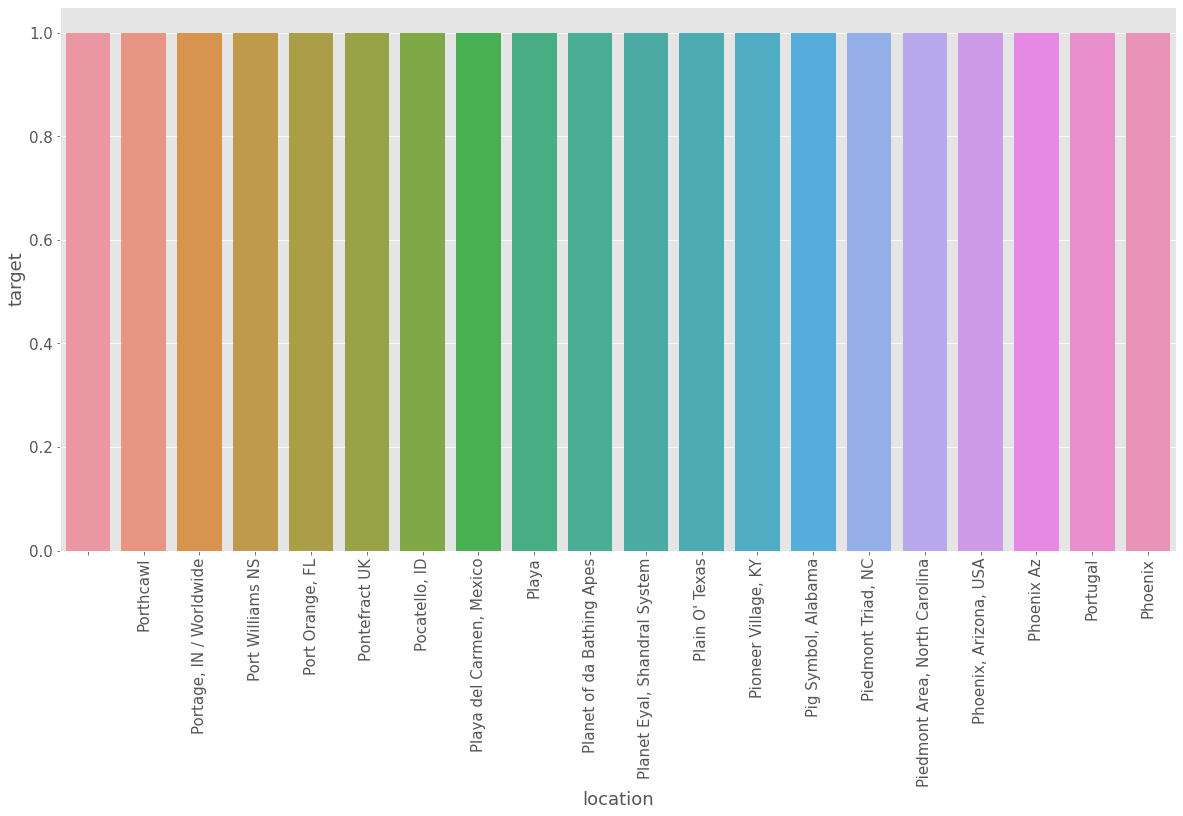

In [25]:
plt.figure(figsize=[20, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET)[:20])
plt.xticks(rotation=90)
plt.show()

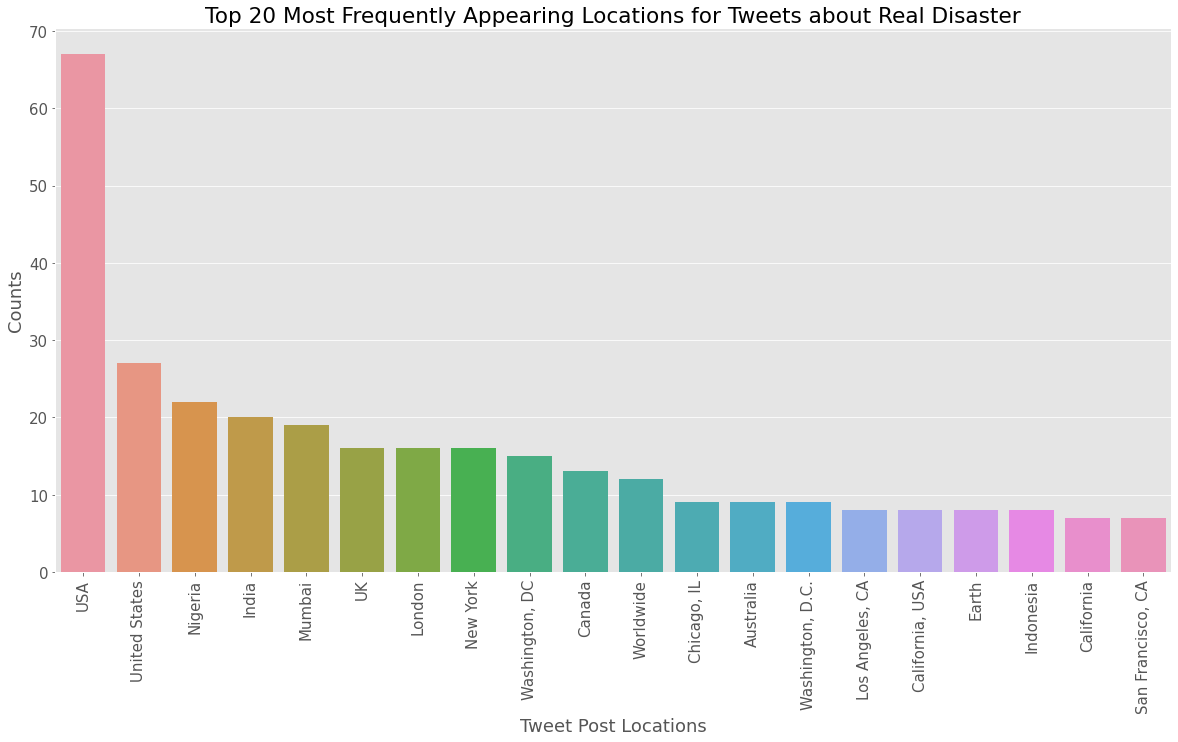

In [26]:
plt.figure(figsize=[20, 10])
sns.barplot(x=LOCATION,
            y=TARGET,
            data=df_train[df_train[TARGET] == 1].groupby(LOCATION)
            [TARGET].count().reset_index().sort_values(by=TARGET,
                                                       ascending=False)[:20])
plt.xticks(rotation=90)
plt.title('Top 20 Most Frequently Appearing Locations for Tweets about Real Disaster')
plt.xlabel('Tweet Post Locations')
plt.ylabel('Counts')
plt.show()

There is an overlap of countries, cities and there are also co-ordinate information plus some gibberish data.

## Text Data Check

Here is have random tweet text checks  to see what is in there

In [27]:
df_train[TEXT][8], df_train[TARGET][8]

("There's an emergency evacuation happening now in the building across the street",
 1)

In [28]:
df_train[TEXT][20], df_train[TARGET][20]

('this is ridiculous....', 0)

In [29]:
df_train[TEXT][1000] , df_train[TARGET][1000]

('#OVOFest Drake straight body bagging Meek on that OVO stage. #ZIPHIMUP!', 0)

In [30]:
df_train[TEXT][2000] , df_train[TARGET][2000]

('@BradleyBrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough',
 0)

## Test Data Check

In [31]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [32]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

**Notes:**

To remove:
1. urls from the texts, 
2. html tags
3. mentions using @.
4. %20 from keywords

Will retain hashtags since importance information lies in hasgtags but will remove the # in them.

# Basic Cleaning

## Cleaning Tests

In [33]:
test_string = 'I am at https://www.nabanita.org www.nabanita.org okay'
url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
test_op = re.sub(url_pattern, '', test_string)
test_op

'I am at   okay'

In [34]:
test_string = 'I am at <p>www.nabanita.org &nbsp;</p>'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org '

In [35]:
test_string = 'I am at <p>www.nabanita.org'
html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at www.nabanita.org'

In [36]:
test_string = 'I am at @nabanita #python testing 123'
html_entities = r'@([a-z0-9]+)|#'
test_op = re.sub(html_entities, '', test_string)
test_op

'I am at  python testing 123'

A tweet might tag news channels as well which contains the word 'news'. If they are twitter handles, then the information will be lost. Hence adding this function to add the keyword news to the tweet if the word is present in the tweet text.

## Implementation

In [37]:
def remove_urls(text):
    ''' This method takes in text to remove urls and website links, if any'''
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    return text

def remove_html_entities(text):
    ''' This method removes html tags'''
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    text = re.sub(html_entities, '', text)
    return text

def convert_lower_case(text):
    return text.lower()

def detect_news(text):
    if 'news' in text:
        text = text + ' news'
    return text

def remove_social_media_tags(text):
    ''' This method removes @ and # tags'''
    tag_pattern = r'@([a-z0-9]+)|#'
    text = re.sub(tag_pattern, '', text)
    return text

# Count it before I remove them altogether
def count_punctuations(text):
    getpunctuation = re.findall('[.?"\'`\,\-\!:;\(\)\[\]\\/“”]+?',text)
    return len(getpunctuation)

def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append(contractions.fix(each_word).lower())
    word_list = [wnl.lemmatize(each_word.strip()) for each_word in word_list if each_word not in STOPWORDS and each_word.strip() != '']
    return " ".join(word_list)

In [38]:
df_train[TEXT] = df_train[TEXT].apply(remove_urls)
df_train[TEXT] = df_train[TEXT].apply(remove_html_entities)
df_train[TEXT] = df_train[TEXT].apply(convert_lower_case)
df_train[TEXT] = df_train[TEXT].apply(detect_news)
df_train[TEXT] = df_train[TEXT].apply(remove_social_media_tags)
df_train[PUNCTUATION_COUNT] = df_train[TEXT].apply(count_punctuations)
df_train[TEXT] = df_train[TEXT].apply(preprocess_text)

In [39]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0


In [40]:
# Test

# Expected to remove @FoxNews but have ' news' in the tweet text

df_train[(df_train[KEYWORD] == 'body%20bags') & (df_train[TARGET] == 1)][TEXT].values

array(['call report dangerous activity tell body bag arrival news'],
      dtype=object)

## Punctuation Analysis

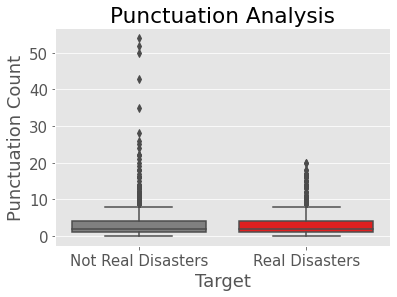

In [41]:
sns.boxplot(x=TARGET,
            y=PUNCTUATION_COUNT,
            data=df_train,
            palette=['grey', 'red'])
plt.title('Punctuation Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Punctuation Count')
plt.show()

In [42]:
def clean_keyword(text):
    if text is not np.nan and text:
        text = text.replace('%20', ' ')
    return text

In [43]:
df_train[KEYWORD] = df_train[KEYWORD].apply(clean_keyword)

## Keyword Check

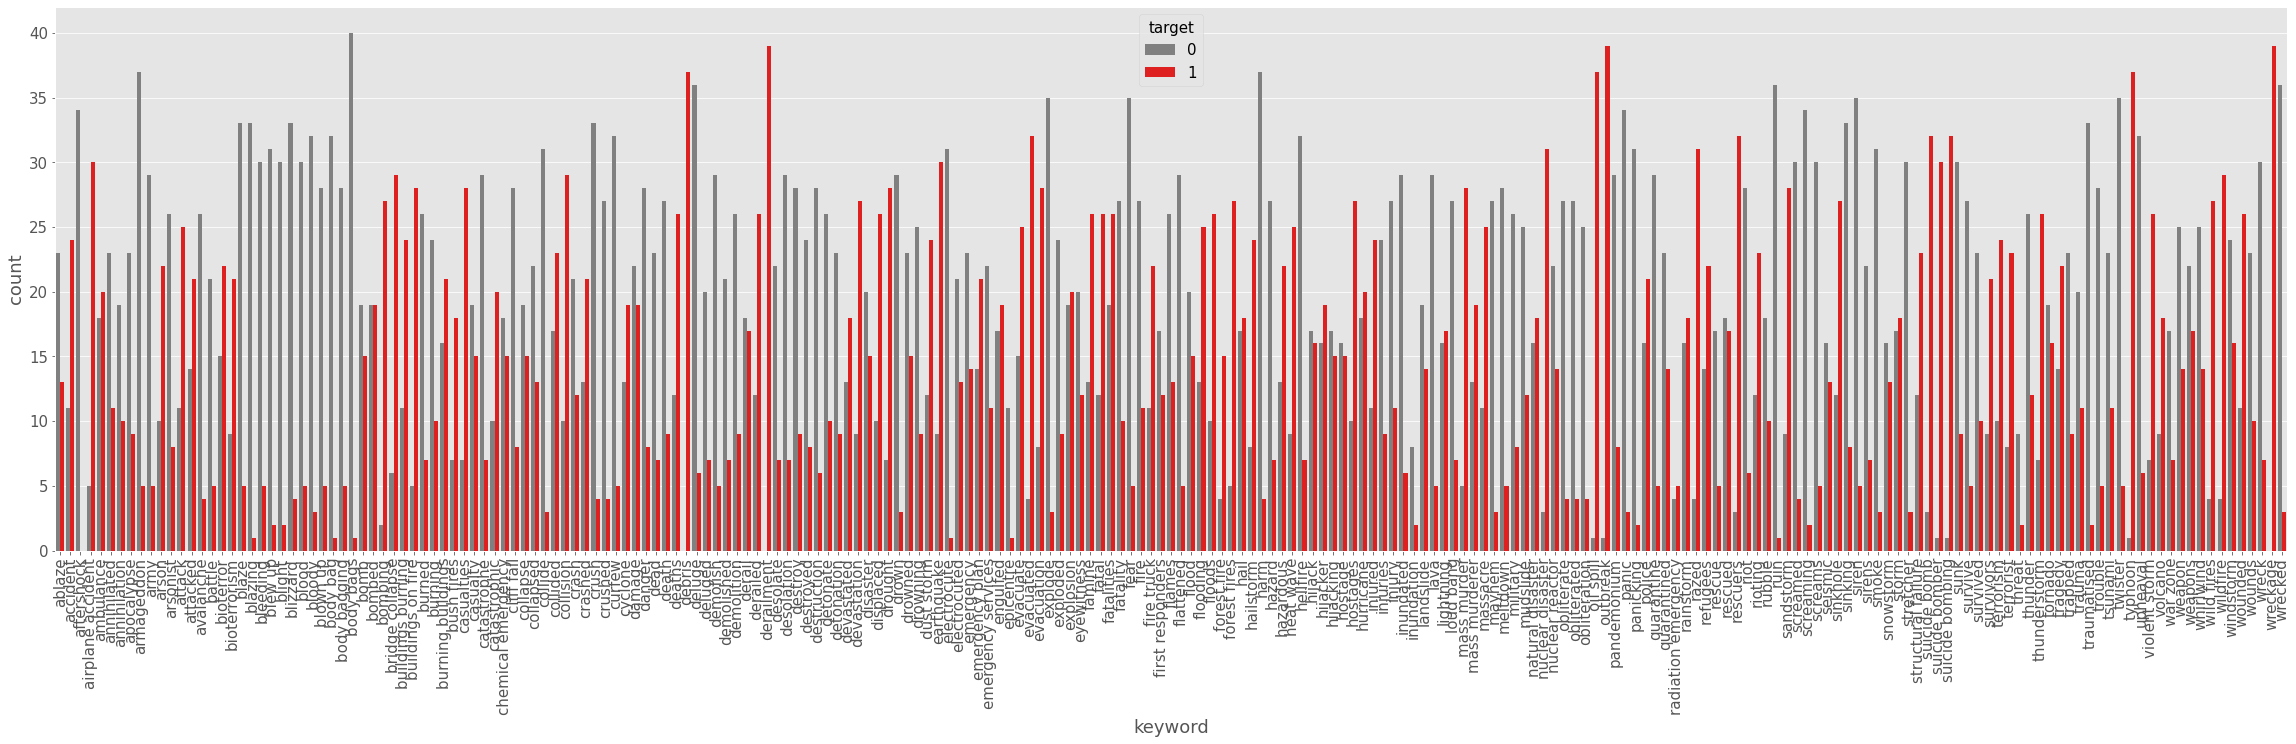

In [44]:
# Testing if %20 is replaced by space

plt.figure(figsize=[40, 10])
sns.countplot(x=KEYWORD, hue=TARGET, data=df_train, palette=['grey', 'red'])
plt.xticks(rotation=90)
plt.show()

# Mention of Numbers in Tweets

In [45]:
def get_numbers_in_tweet(text):
    list_numbers = re.findall(r'\d+', text)
    if list_numbers:
        return 1
    return 0

In [46]:
df_train[NUM_IN_TWEETS] = df_train[TEXT].apply(get_numbers_in_tweet)

In [47]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           7613 non-null   int64 
 1   keyword                      7552 non-null   object
 2   location                     5080 non-null   object
 3   text                         7613 non-null   object
 4   target                       7613 non-null   int64 
 5   Punctuation Count Per Tweet  7613 non-null   int64 
 6   Number in Tweet              7613 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 416.5+ KB


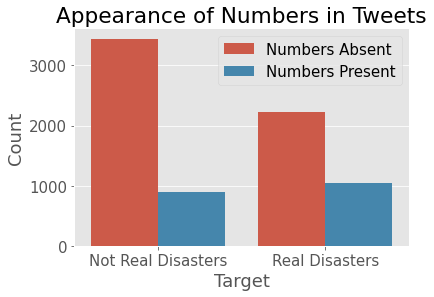

In [48]:
sns.countplot(x=TARGET, hue=NUM_IN_TWEETS, data=df_train)
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks = [0, 1])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Appearance of Numbers in Tweets')
plt.legend(labels=['Numbers Absent', 'Numbers Present'])
plt.show()

The probability of having numbers in tweets about real disasters.

# Sentiment Analysis

In [49]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [50]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

In [51]:
df_train[SENTIMENT] = df_train[TEXT].apply(lambda x: nlp(x)._.polarity)

In [52]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0,0,0.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,0,0.1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3,0,-0.1
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1,1,0.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0


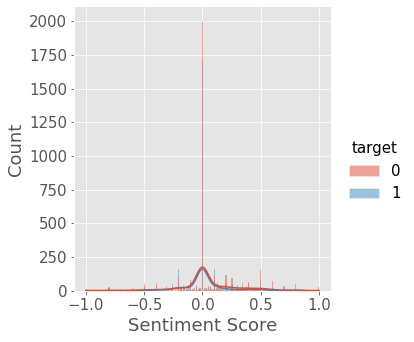

In [53]:
sns.displot(x=SENTIMENT, hue=TARGET, data=df_train, kde=True)
plt.show()

In [54]:
def sentiment_to_binary(x):
    if x > 0:
        return 1
    else:
        return 0

In [55]:
df_train[SENTIMENT_ROUND] = df_train[SENTIMENT].apply(sentiment_to_binary)
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off)
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0,0,0.0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,0,0.1,1
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3,0,-0.1,0
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1,1,0.0,0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0


In [56]:
df_train[SENTIMENT_ROUND].value_counts()

0    5276
1    2337
Name: Sentiment Score (rounded off), dtype: int64

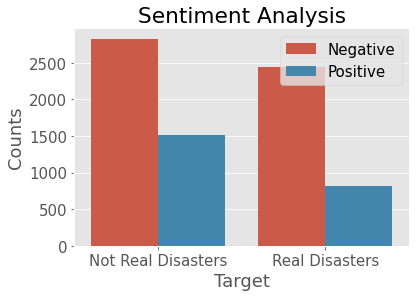

In [57]:
sns.countplot(x=TARGET, hue=SENTIMENT_ROUND, data=df_train)
plt.title('Sentiment Analysis')
plt.xticks(labels=['Not Real Disasters', 'Real Disasters'], ticks=[0, 1])
plt.xlabel('Target')
plt.ylabel('Counts')
# plt.ylabel('Punctuation Count')
plt.legend(labels=['Negative', 'Positive'])
plt.show()

Since this data will be used later for modelling, I will use a label encoder in the pipeline to get rid of the negative number.

# Tweet Length Analysis

In [58]:
df_train[TEXT_TOKENIZED] = df_train[TEXT].apply(word_tokenize)

In [59]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Text Tokenized
0,1,NaN,NaN,deed reason earthquake may allah forgive u,1,0,0,0.0,0,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,0,0.1,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,resident asked shelter place notified officer ...,1,3,0,-0.1,0,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,1,1,0.0,0,"[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [60]:
df_train[WORDS_PER_TWEET] = df_train[TEXT_TOKENIZED].apply(len)
df_train[CHAR_PER_TWEET] = df_train[TEXT].apply(len)

No handles with labels found to put in legend.


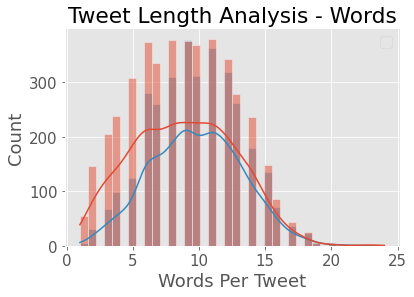

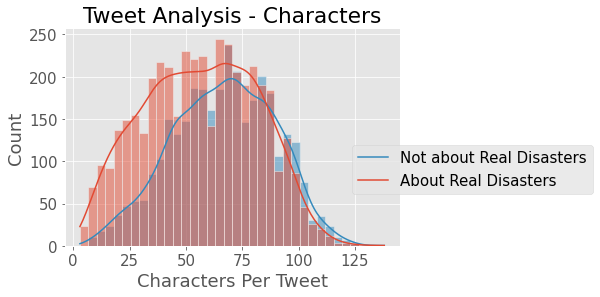

In [61]:
sns.histplot(x=WORDS_PER_TWEET, hue=TARGET, data=df_train, kde=True)
plt.title('Tweet Length Analysis - Words')
plt.legend()
plt.show()
sns.histplot(x=CHAR_PER_TWEET, hue=TARGET, data=df_train, kde=True)
plt.title('Tweet Analysis - Characters')
plt.legend(labels=['Not about Real Disasters', 'About Real Disasters'], loc='best', bbox_to_anchor=(1.1, 0., 0.5, 0.5))
plt.show()

# Tweet Text Analysis using WordCloud

In [62]:
real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 1][TEXT]))

In [63]:
non_real_disaster_tweets = ' '. join(list(df_train[df_train[TARGET] == 0][TEXT]))

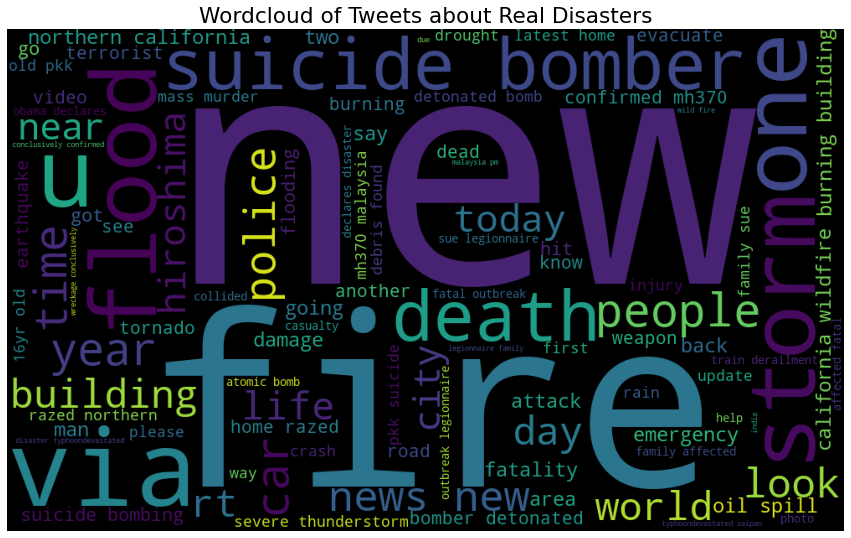

In [64]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600, 
               random_state=1).generate(real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets about Real Disasters")
plt.show()

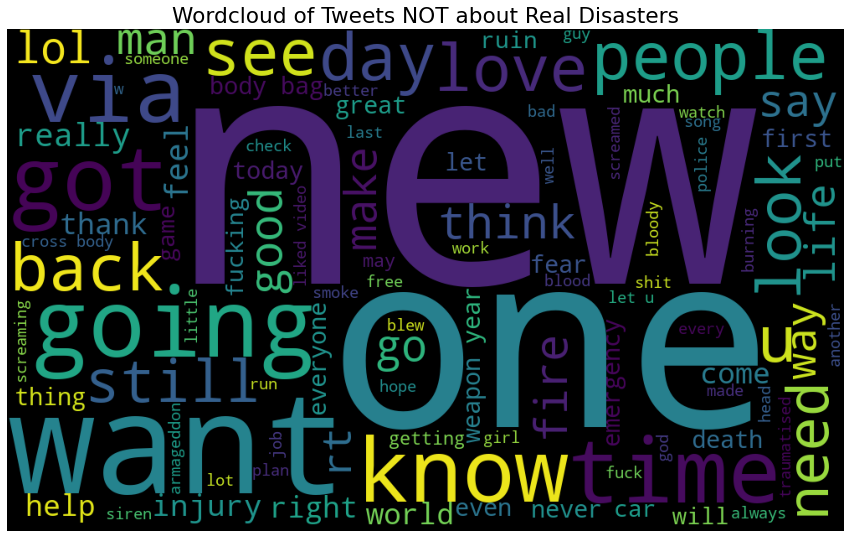

In [65]:
wc = WordCloud(background_color="black", 
               max_words=100, 
               width=1000, 
               height=600,
               font_step=1,
               random_state=1).generate(non_real_disaster_tweets)

plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.title("Wordcloud of Tweets NOT about Real Disasters")
plt.show()

Emojis are present in the text, as evident on the wordcloud. Therefore, they need to be either detected or removed. I will not be addressing emoji detection in this project.

In [66]:
from collections import Counter
term_freq = dict(Counter(real_disaster_tweets.split(' ')))
sorted_terms_freq = dict(sorted(term_freq.items(), key=lambda x: x[1], reverse=True))
bow = [k for k, v in sorted_terms_freq.items() if v > 35]  # To check the words appearing to create the below list.

In [67]:
bow = [
    'news', 'fire', 'suicide', 'disaster', 'killed', 'storm', 'crash',
    'emergency', 'bomb', 'nuclear', 'wildfire', 'accident', 'bombing',
    'attack', 'burning', 'dead', 'bomber', 'war', 'families', 'atomic',
    'fatal', 'collapse', 'debris', 'water', 'mass', 'severe', 'warning',
    'injured', 'oil', 'spill', 'floods', 'wreckage', 'earthquake',
    'evacuation', 'derailment', 'outbreak', 'thunderstorm', 'flood', 'missing',
    'flooding'
]

def is_word_in_bow(x):
    for word in x.split(' '):
        if word in bow:
            return 1
    return 0

df_train[IN_BOW] = df_train[TEXT].apply(is_word_in_bow)

<AxesSubplot:xlabel='Present In BOW', ylabel='count'>

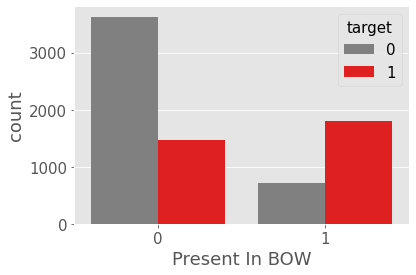

In [68]:
sns.countplot(data=df_train, x=IN_BOW, hue=TARGET, palette=['grey', 'red'])

# Correlation between Tweet Length and Punctuation Count

<AxesSubplot:>

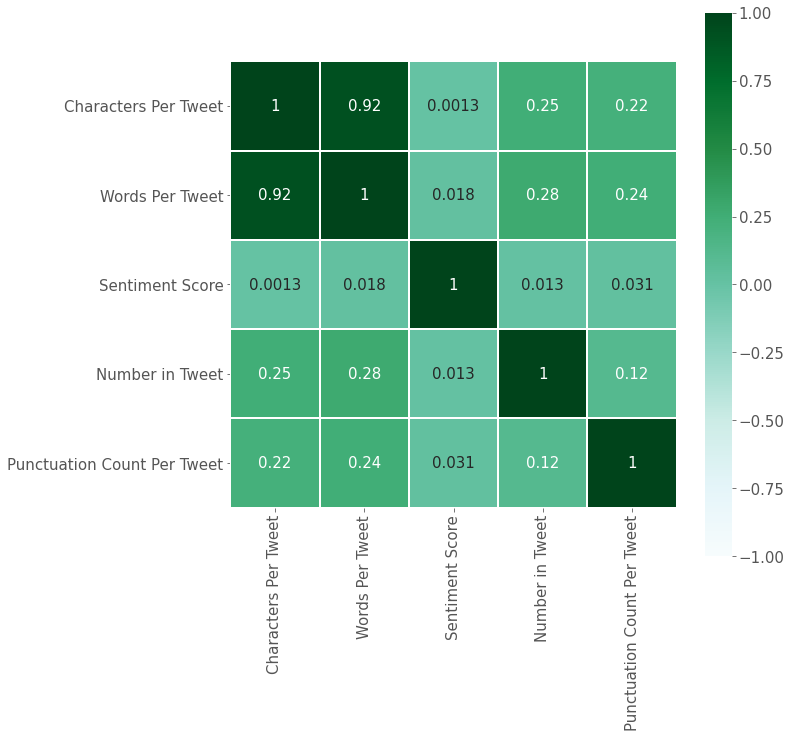

In [69]:
plt.figure(figsize=[10,10])
sns.heatmap(df_train[[CHAR_PER_TWEET, WORDS_PER_TWEET, SENTIMENT, NUM_IN_TWEETS , PUNCTUATION_COUNT]].corr(),
            annot=True, square=True, vmin=-1, vmax=1, linewidths=1, cmap='BuGn'
           )

# Location Analysis

In [70]:
# import time
# from geopy.geocoders import Nominatim

# geolocator = Nominatim(user_agent="my_app")

# def print_location(loc):
#     if loc:
#         try:
#             location = geolocator.geocode(loc)
#             return location
#         except:
#             time.sleep(1)
#             try:
#                 location = geolocator.geocode(loc)
#                 return location
#             except:
#                 print(loc)

# df_train[_LOCATION_] = df_train[LOCATION].apply(lambda x: print_location(x))
# df_train.head()

In [71]:
def check_location(x):
    ''' This method checks if the tweet location has any actual location 
    and saves them as as space-separated value if more than one.
    If no location is found, then save blank'''
    spacy_loc = nlp(x)
    num_loc_in_tweet = len([ent.label_ for ent in spacy_loc.ents if ent.label_ == 'GPE'])
    if num_loc_in_tweet:
        locs_in_tweet = [ent.text for ent in spacy_loc.ents if ent.label_ == 'GPE']
    else:
        return [], 0
    return locs_in_tweet, 1

df_train[LOCATION].fillna('', inplace=True)
df_train[LOCATIONS], df_train[IDENTIFIABLE_LOCATION] = zip(*df_train[LOCATION].apply(check_location))

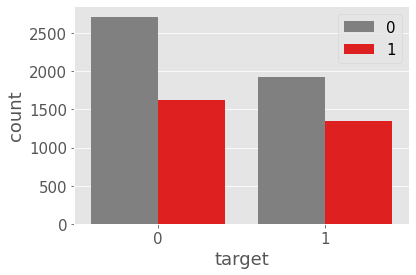

In [72]:
sns.countplot(x=TARGET, hue=IDENTIFIABLE_LOCATION, data=df_train, palette=['grey', 'red'])
plt.legend()
plt.show()

The previous method to fill up and standardize the locations did not work since it is likely a paid service and after a few requests, the API stops working.

# Final Text Data Preparation

In [73]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Text Tokenized,Words Per Tweet,Characters Per Tweet,Present In BOW,Locations,Identifiable Location
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,0.0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,1,[],0
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,0.1,1,"[forest, fire, near, la, ronge, sask, canada]",7,37,1,[],0
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,-0.1,0,"[resident, asked, shelter, place, notified, of...",11,85,1,[],0
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,0.0,0,"[13000, people, receive, wildfire, evacuation,...",7,57,1,[],0
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,1,[],0


In [74]:
df_train[ALL_TEXT] = df_train[TEXT_TOKENIZED] + df_train[LOCATIONS]
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Text Tokenized,Words Per Tweet,Characters Per Tweet,Present In BOW,Locations,Identifiable Location,all_text
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,0.0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,1,[],0,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,0.1,1,"[forest, fire, near, la, ronge, sask, canada]",7,37,1,[],0,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,-0.1,0,"[resident, asked, shelter, place, notified, of...",11,85,1,[],0,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,0.0,0,"[13000, people, receive, wildfire, evacuation,...",7,57,1,[],0,"[13000, people, receive, wildfire, evacuation,..."
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,1,[],0,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [75]:
target = df_train[TARGET].values

In [76]:
df_train[ALL_TEXT_JOINED] = df_train[ALL_TEXT].apply(lambda x: " ".join(x))

The training data is ready now. Next step, prepping the test data.

# Test Data Preparation

In [77]:
df_test[TEXT] = df_test[TEXT].apply(remove_urls)
df_test[TEXT] = df_test[TEXT].apply(remove_html_entities)
df_test[TEXT] = df_test[TEXT].apply(convert_lower_case)
df_test[TEXT] = df_test[TEXT].apply(detect_news)
df_test[TEXT] = df_test[TEXT].apply(remove_social_media_tags)
df_test[PUNCTUATION_COUNT] = df_test[TEXT].apply(count_punctuations)
df_test[TEXT] = df_test[TEXT].apply(preprocess_text)

df_test[KEYWORD] = df_test[KEYWORD].apply(clean_keyword)

df_test[NUM_IN_TWEETS] = df_test[TEXT].apply(get_numbers_in_tweet)
df_test[SENTIMENT] = df_test[TEXT].apply(lambda x: nlp(x)._.polarity)
df_test[SENTIMENT_ROUND] = df_test[SENTIMENT].apply(round)

df_test[LOCATION].fillna('', inplace=True)
df_test[LOCATIONS], df_test[IDENTIFIABLE_LOCATION] = zip(*df_test[LOCATION].apply(check_location))

df_test[TEXT_TOKENIZED] = df_test[TEXT].apply(word_tokenize)

df_test[WORDS_PER_TWEET] = df_test[TEXT_TOKENIZED].apply(len)
df_test[CHAR_PER_TWEET] = df_test[TEXT].apply(len)

df_test[IN_BOW] = df_test[TEXT].apply(is_word_in_bow)

df_test[ALL_TEXT] = df_test[TEXT_TOKENIZED] + df_test[LOCATIONS]
df_test[ALL_TEXT_JOINED] = df_test[ALL_TEXT].apply(lambda x: " ".join(x))

The test data is ready now.

In [78]:
df_test.head()

,id,keyword,location,text,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Locations,Identifiable Location,Text Tokenized,Words Per Tweet,Characters Per Tweet,Present In BOW,all_text,all_text_joined
0,0,NaN,,happened terrible car crash,0,0,-1.00,-1,[],0,"[happened, terrible, car, crash]",4,27,1,"[happened, terrible, car, crash]",happened terrible car crash
1,2,NaN,,heard earthquake different city stay safe ever...,2,0,0.25,0,[],0,"[heard, earthquake, different, city, stay, saf...",7,50,1,"[heard, earthquake, different, city, stay, saf...",heard earthquake different city stay safe ever...
2,3,NaN,,forest fire spot pond goose fleeing across str...,2,0,0.00,0,[],0,"[forest, fire, spot, pond, goose, fleeing, acr...",11,61,1,"[forest, fire, spot, pond, goose, fleeing, acr...",forest fire spot pond goose fleeing across str...
3,9,NaN,,apocalypse lighting spokane wildfire,1,0,0.00,0,[],0,"[apocalypse, lighting, spokane, wildfire]",4,36,1,"[apocalypse, lighting, spokane, wildfire]",apocalypse lighting spokane wildfire
4,11,NaN,,typhoon soudelor kill 28 china taiwan,0,1,0.00,0,[],0,"[typhoon, soudelor, kill, 28, china, taiwan]",6,37,0,"[typhoon, soudelor, kill, 28, china, taiwan]",typhoon soudelor kill 28 china taiwan


In [79]:
df_train.head()

,id,keyword,location,text,target,Punctuation Count Per Tweet,Number in Tweet,Sentiment Score,Sentiment Score (rounded off),Text Tokenized,Words Per Tweet,Characters Per Tweet,Present In BOW,Locations,Identifiable Location,all_text,all_text_joined
0,1,NaN,,deed reason earthquake may allah forgive u,1,0,0,0.0,0,"[deed, reason, earthquake, may, allah, forgive...",7,42,1,[],0,"[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,,forest fire near la ronge sask canada,1,1,0,0.1,1,"[forest, fire, near, la, ronge, sask, canada]",7,37,1,[],0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,,resident asked shelter place notified officer ...,1,3,0,-0.1,0,"[resident, asked, shelter, place, notified, of...",11,85,1,[],0,"[resident, asked, shelter, place, notified, of...",resident asked shelter place notified officer ...
3,6,NaN,,13000 people receive wildfire evacuation order...,1,1,1,0.0,0,"[13000, people, receive, wildfire, evacuation,...",7,57,1,[],0,"[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,,got sent photo ruby alaska smoke wildfire pour...,1,0,0,0.0,0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,54,1,[],0,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


In [80]:
df_train.to_csv('../data/df_train_prepped.csv', index=False)
df_test.to_csv('../data/df_test_prepped.csv', index=False)